# Sensex Stock Movement Prediction using Machine Learning

### 🎯 Objective:
Develop an algorithmic trading model to predict whether the S&P BSE Sensex will go up or down the next day using technical indicators.

In [50]:
# 📦 Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


In [51]:
# 📈 Fetch historical Sensex data (5 years)
sensex_data = yf.download("^BSESN", start="2018-01-01", end="2023-01-01")
# Flatten the multi-index column names
sensex_data.columns = [col[0] for col in sensex_data.columns]

# Now the columns are: 'Close', 'High', 'Low', 'Open', 'Volume'

sensex_data.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2018-01-01,33812.750000,34101.128906,33766.148438,34059.988281,7500
2018-01-02,33812.261719,33964.140625,33703.371094,33913.550781,10600
2018-01-03,33793.378906,33998.371094,33765.429688,33929.609375,9000
2018-01-04,33969.640625,33995.398438,33802.128906,33912.488281,10500
2018-01-05,34153.851562,34188.851562,34020.839844,34021.269531,14700


In [52]:
# 📊 Exploratory Data Analysis (EDA)
sensex_data.info()
sensex_data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1231 entries, 2018-01-01 to 2022-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1231 non-null   float64
 1   High    1231 non-null   float64
 2   Low     1231 non-null   float64
 3   Open    1231 non-null   float64
 4   Volume  1231 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 57.7 KB


,Close,High,Low,Open,Volume
count,1231.000000,1231.000000,1231.000000,1231.000000,1.231000e+03
mean,44709.017775,44986.804930,44427.980697,44754.866672,2.716909e+05
std,9836.318202,9856.510460,9795.198642,9821.393378,2.122147e+06
min,25981.240234,27462.869141,25638.900391,26499.810547,0.000000e+00
25%,36362.335938,36577.875000,36146.660156,36415.589844,9.100000e+03
50%,40286.480469,40542.398438,40066.539062,40316.500000,1.400000e+04
75%,54399.041016,54769.199219,54149.044922,54460.628906,1.985000e+04
max,63284.191406,63583.070312,63183.769531,63357.988281,3.181510e+07


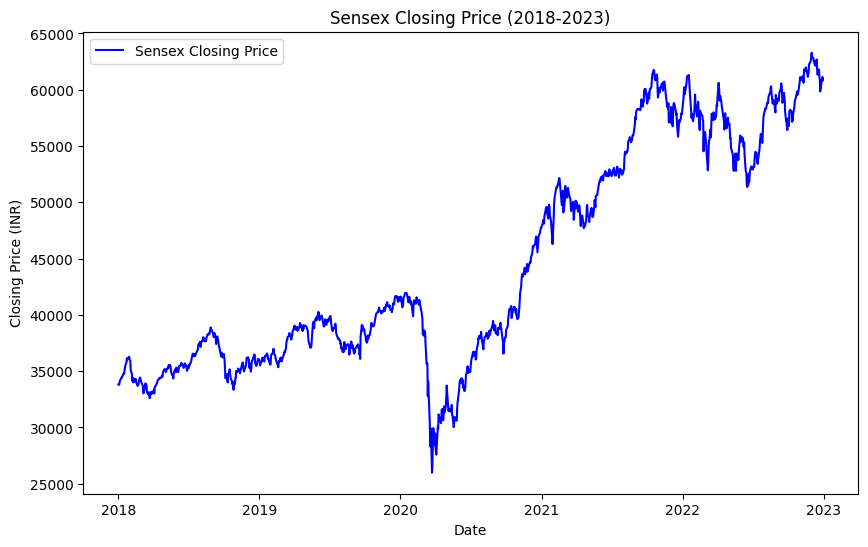

In [53]:
# 🖼️ Plot closing price over time
plt.figure(figsize=(10, 6))
plt.plot(sensex_data['Close'], label='Sensex Closing Price', color='blue')
plt.title("Sensex Closing Price (2018-2023)")
plt.xlabel("Date")
plt.ylabel("Closing Price (INR)")
plt.legend()
plt.show()

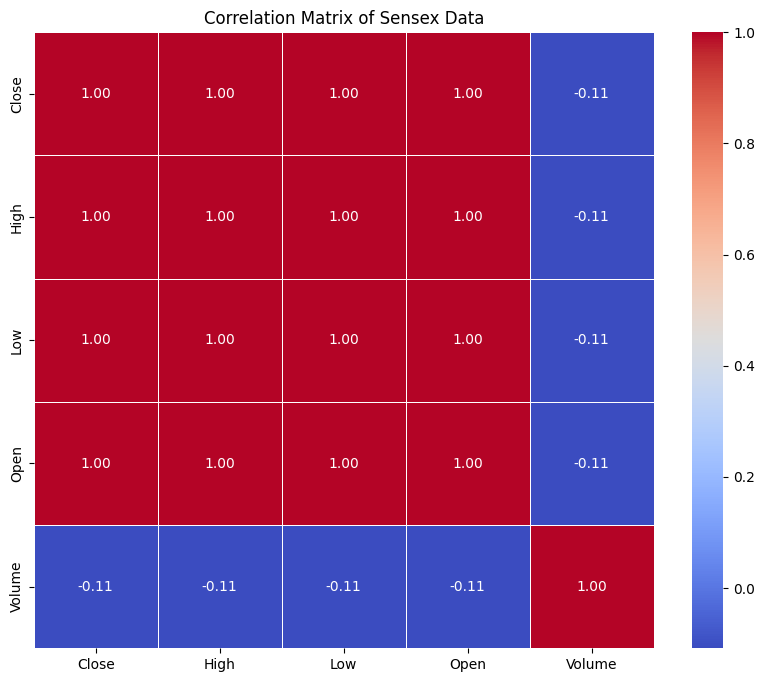

In [54]:
# 🔍 Correlation heatmap
corr_matrix = sensex_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Sensex Data")
plt.show()

In [55]:
# 🛠️ Feature Engineering
sensex_data['SMA_20'] = sensex_data['Close'].rolling(window=20).mean()
sensex_data['SMA_50'] = sensex_data['Close'].rolling(window=50).mean()
sensex_data['SMA_200'] = sensex_data['Close'].rolling(window=200).mean()
sensex_data['Daily_Return'] = sensex_data['Close'].pct_change()
sensex_data.dropna(inplace=True)
# --- SECTION 4.1: ADVANCED FEATURE ENGINEERING (More Indicators) ---

import ta  # this should be imported here if not already

# 1. Relative Strength Index (RSI)
sensex_data['RSI'] = ta.momentum.RSIIndicator(close=sensex_data['Close'], window=14).rsi()

# 2. MACD
macd = ta.trend.MACD(close=sensex_data['Close'])
sensex_data['MACD'] = macd.macd()
sensex_data['MACD_Signal'] = macd.macd_signal()

# 3. Bollinger Bands
bb = ta.volatility.BollingerBands(close=sensex_data['Close'])
sensex_data['BB_Upper'] = bb.bollinger_hband()
sensex_data['BB_Lower'] = bb.bollinger_lband()

# 4. Momentum (5-day)
sensex_data['Momentum_5'] = sensex_data['Close'] - sensex_data['Close'].shift(5)

# 5. Average True Range (ATR)
atr = ta.volatility.AverageTrueRange(
    high=sensex_data['High'], low=sensex_data['Low'], close=sensex_data['Close']
)
sensex_data['ATR'] = atr.average_true_range()

# 6. Volume Change
sensex_data['Volume_Change'] = sensex_data['Volume'].pct_change()

# 7. Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(
    high=sensex_data['High'], low=sensex_data['Low'], close=sensex_data['Close']
)
sensex_data['Stoch_K'] = stoch.stoch()
sensex_data['Stoch_D'] = stoch.stoch_signal()

# Drop rows with missing values after feature creation
sensex_data.dropna(inplace=True)

sensex_data[['Close', 'SMA_20', 'SMA_50', 'SMA_200', 'Daily_Return']].head()

,Close,SMA_20,SMA_50,SMA_200,Daily_Return
Date,,,,,
2018-12-11,35150.011719,35536.904687,35055.615859,35456.691289,0.005443
2018-12-12,35779.070312,35568.633789,35044.713828,35466.713340,0.017896
2018-12-13,35929.640625,35608.016406,35038.763828,35477.843594,0.004208
2018-12-14,35962.929688,35643.135938,35027.499609,35488.433945,0.000927
2018-12-17,36270.070312,35683.781445,35033.388437,35500.686797,0.008540


In [56]:
# 🎯 Create target variable
sensex_data['Target'] = np.where(sensex_data['Daily_Return'] > 0, 1, 0)
sensex_data[['Close', 'Daily_Return', 'Target']].tail()

,Close,Daily_Return,Target
Date,,,
2022-12-26,60566.421875,0.012050,1
2022-12-27,60927.429688,0.005961,1
2022-12-28,60910.281250,-0.000281,0
2022-12-29,61133.878906,0.003671,1
2022-12-30,60840.738281,-0.004795,0


In [57]:
# Select features and target
X = sensex_data[[
    'SMA_20', 'SMA_50', 'SMA_200', 'Daily_Return',
    'RSI', 'MACD', 'MACD_Signal',
    'BB_Upper', 'BB_Lower', 'Momentum_5',
    'ATR', 'Volume_Change', 'Stoch_K', 'Stoch_D'
]].copy()  # 👈 Add .copy() to avoid warnings

y = sensex_data['Target']

# Clean infinities and NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = y.loc[X.index]  # Align target with cleaned features

# Split and scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [58]:
# 🤖 Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 1.0000


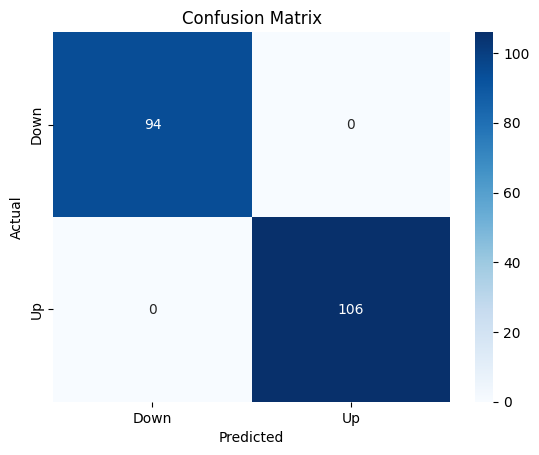

In [59]:
# 📈 Predict and evaluate
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [60]:
# 🔁 Cross-validation
cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5)
print(f"CV scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f}")

CV scores: [1. 1. 1. 1. 1.]
Mean CV Score: 1.0000


In [61]:
# 🔧 Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 1.0
